In [1]:
import category_encoders as ce
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df = pd.read_csv('wine_dataset.csv')
df = df.drop(columns = ['Unnamed: 0', 'designation', 'region_2', 'taster_twitter_handle', 'winery'])
df = df.drop_duplicates(ignore_index=True)

for i in range(len(df)):
    num = df.loc[[i]].isna().sum().sum()
    if num >=2: 
        df.drop(i, axis = 0, inplace=True)
        
df['price'].fillna(df['price'].median(), inplace=True)
df['region_1'].fillna(str(df['region_1'].mode()), inplace=True)
df['taster_name'].fillna(0, inplace=True)

In [3]:
analyzerObj = SentimentIntensityAnalyzer()

df['descLen'] = df['description'].map(lambda description: len(description))
df['compound'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['compound'])
df['year'] = df['title'].map(lambda title: re.search(r"(\d{4})", title).group(1) if re.search(r"(\d{4})", title) else '0')

df = df.drop(columns = ['description', 'title'])

In [4]:
df['year'] = pd.to_numeric(df['year'])
df.loc[df['year'] == 7200]
df.at[7057, 'year'] = 2007
median = df.loc[df['year']>0].median()
median = median[4]
df['year'].replace(0, median, inplace = True)
df.describe()

,points,price,descLen,compound,year
count,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000
mean,88.469898,35.070687,244.020345,0.517049,2010.698671
std,3.038932,40.222552,66.422905,0.370791,4.844967
min,80.000000,5.000000,53.000000,-0.840200,1848.000000
25%,86.000000,17.000000,198.000000,0.296000,2009.000000
50%,88.000000,25.000000,238.000000,0.636900,2011.000000
75%,91.000000,40.000000,284.000000,0.822500,2013.000000
max,100.000000,1300.000000,653.000000,0.988700,2017.000000


In [5]:
ce_ord = ce.OrdinalEncoder(cols = ['country', 'province', 'region_1', 'taster_name', 'variety'])
data = ce_ord.fit_transform(df, df['points'])


/Users/camila/miniconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [6]:
data.head()

,country,points,price,province,region_1,taster_name,variety,descLen,compound,year
0,1,90,30.0,1,1,1,1,222,0.9403,2012.0
1,2,87,22.0,2,2,2,2,174,0.4404,2014.0
3,3,92,50.0,3,3,3,3,268,0.6705,2012.0
4,3,93,38.0,3,3,3,4,326,0.4404,2013.0
5,3,84,14.0,3,4,4,4,133,0.6908,2012.0


IMPORTS AND CLIENT SETUP

In [7]:
from py_muvr import FeatureSelector # also had to install libomp from brew

In [8]:
from dask.distributed import Client

In [9]:
client = Client()
executor = client.get_executor()

Separate predictor variables from target variable (points)

In [10]:
X = data.drop(columns=["points"]).values
y = data.points.values

Feature Selection

Estimator is the ML model used to evaluate the features.
Metrics is from scikit learn

In [11]:
estimator = "PLSR"
metric = "neg_mean_squared_error"

In [12]:
fs = FeatureSelector(
    n_outer=6,
    n_inner=5,
    n_repetitions=8,
    metric=metric,
    estimator=estimator,
    features_dropout_rate=0.05,
    random_state=1
)

In [13]:
fs.fit(X, y, executor=executor)

2021-06-16 17:17:13 py_muvr.feature_selector   INFO    Groups parameter is not specified: independent samples assumed
2021-06-16 17:17:13 py_muvr.feature_selector   INFO    Running 8 repetitions and 6 outer loops using executor ClientExecutor.
2021-06-16 17:17:13 py_muvr.feature_selector   INFO    Scheduling tasks...


N/A% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/camila/miniconda3/lib/python3.7/site-packages/distributed/worker.py:3693: UserWarning: Large object of size 3.09 MiB detected in task graph: 
  (InputDataset(X=array([[1.000e+00, 3.000e+01, 1.00 ... t 0x11c262320>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
100% (48 of 48) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


2021-06-16 17:17:16 py_muvr.feature_selector   INFO    Retrieving results...


100% (48 of 48) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


2021-06-16 17:17:23 py_muvr.feature_selector   INFO    Finished feature selection.


FeatureSelector(repetitions=8, n_outer=6, n_inner=5, feature_dropout_rate=0.05, is_fit=True)

In [14]:
feature_names = data.drop(columns=["points"]).columns

In [15]:
selected_features = fs.get_selected_features()
selected_feature_names = fs.get_selected_features(feature_names)

In [16]:
print(selected_features["min"])
print(selected_feature_names["min"])

[6, 1, 7, 8]
['descLen', 'price', 'compound', 'year']


In [17]:
print(selected_features["mid"])
print(selected_feature_names["mid"])

[6, 1, 7, 8, 0, 2]
['descLen', 'price', 'compound', 'year', 'country', 'province']


In [18]:
print(selected_features["max"])
print(selected_feature_names["max"])

[6, 1, 7, 8, 0, 2, 5, 3, 4]
['descLen', 'price', 'compound', 'year', 'country', 'province', 'variety', 'region_1', 'taster_name']


In [19]:
feature_ranks_df = fs.get_average_ranks_df(feature_names)
feature_ranks_df.head()

,min,mid,max
country,5.0,4.979167,4.958333
price,2.0,2.0,2.0
province,NaN,6.0,6.166667
region_1,NaN,NaN,8.0
taster_name,NaN,NaN,9.0


In [20]:
feature_selection_results = fs.get_feature_selection_results(feature_names)
from py_muvr.plot_utils import plot_validation_curves, plot_feature_rank


/Users/camila/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


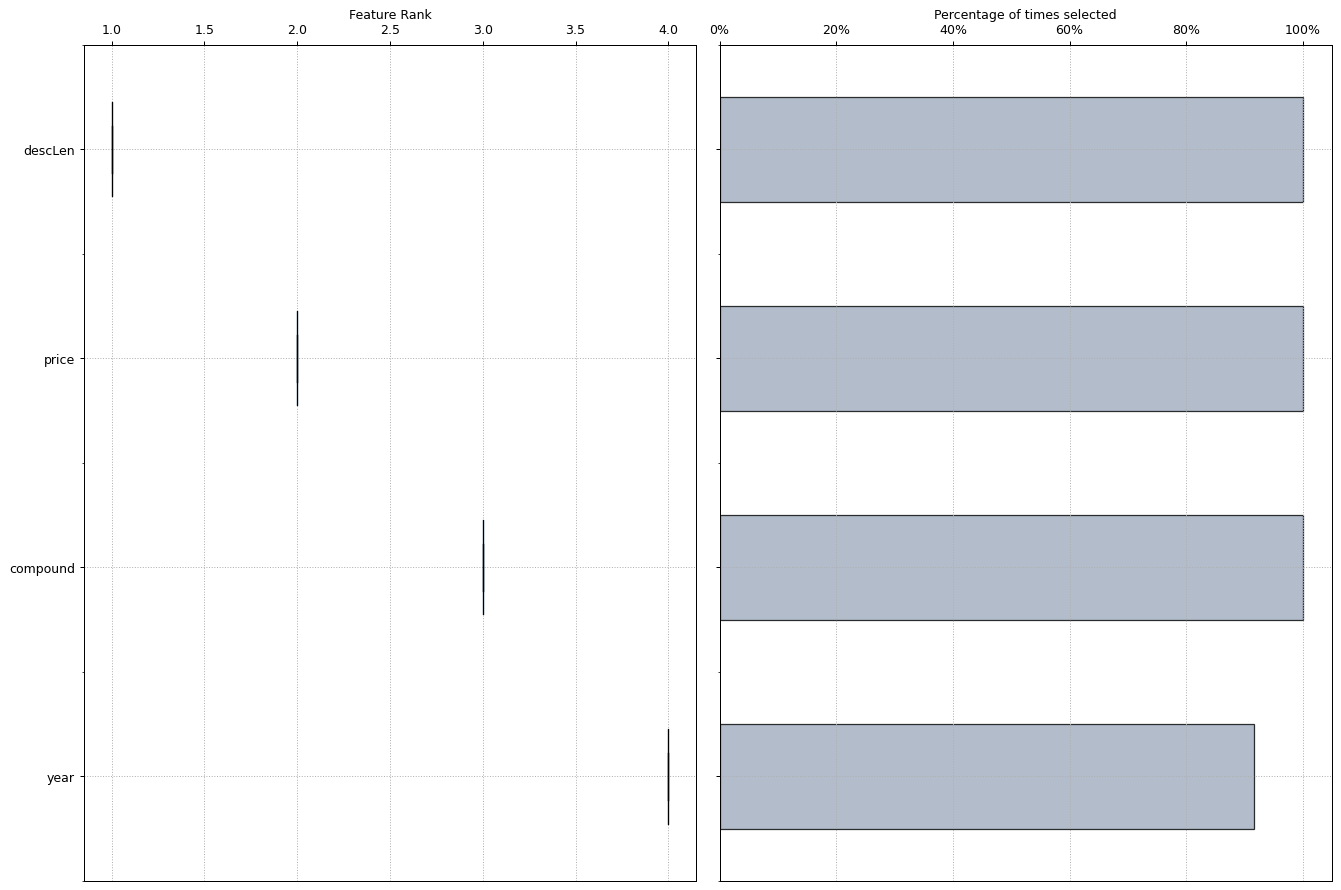

In [21]:
_ = plot_feature_rank(feature_selection_results, "min", feature_names=feature_names, figsize=(15, 10), dpi=90)